### Binary Classification Model for In-Vehicle Coupon Recommendation Using Python and TensorFlow
### David Lowe
### December 15, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The In-Vehicle Coupon Recommendation dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset, available from UC Irvine's Machine Learning Repository, studies whether a person will accept the coupon recommended to him under different driving scenarios.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average accuracy benchmark of 0.7211 after running for 30 epochs. When we applied the final model to the test dataset, the model achieved an accuracy score of 0.7386.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: In-Vehicle Coupon Recommendation Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/in+vehicle+coupon+recommendation

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

2021-12-13 22:33:36.034490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 22:33:36.034561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 30
BATCH_SIZE = 16

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-in-vehicle-coupon-recommendation/in-vehicle-coupon-recommendation.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8           

In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [13]:
print(df_dataset_import.describe())

        temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
count  12684.000000  12684.000000           12684.0       12684.000000   
mean      63.301798      0.414144               1.0           0.561495   
std       19.154486      0.492593               0.0           0.496224   
min       30.000000      0.000000               1.0           0.000000   
25%       55.000000      0.000000               1.0           0.000000   
50%       80.000000      0.000000               1.0           1.000000   
75%       80.000000      1.000000               1.0           1.000000   
max       80.000000      1.000000               1.0           1.000000   

       toCoupon_GEQ25min  direction_same  direction_opp             Y  
count       12684.000000    12684.000000   12684.000000  12684.000000  
mean            0.119126        0.214759       0.785241      0.568433  
std             0.323950        0.410671       0.410671      0.495314  
min             0.000000        0.000000     

In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64
Total number of NaN in the dataframe:  13370


### 1.d) Data Cleaning

In [15]:
# Dropping features that have too many NA's or have no variation
df_dataset_import.drop(columns=['car','toCoupon_GEQ5min','direction_opp'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Y':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

            income    Bar CoffeeHouse CarryAway RestaurantLessThan20  \
0  $37500 - $49999  never       never       NaN                  4~8   
1  $37500 - $49999  never       never       

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [17]:
print(df_dataset_import.describe())

        temperature  has_children  toCoupon_GEQ15min  toCoupon_GEQ25min  \
count  12684.000000  12684.000000       12684.000000       12684.000000   
mean      63.301798      0.414144           0.561495           0.119126   
std       19.154486      0.492593           0.496224           0.323950   
min       30.000000      0.000000           0.000000           0.000000   
25%       55.000000      0.000000           0.000000           0.000000   
50%       80.000000      0.000000           1.000000           0.000000   
75%       80.000000      1.000000           1.000000           0.000000   
max       80.000000      1.000000           1.000000           1.000000   

       direction_same        target  
count    12684.000000  12684.000000  
mean         0.214759      0.568433  
std          0.410671      0.495314  
min          0.000000      0.000000  
25%          0.000000      0.000000  
50%          0.000000      1.000000  
75%          0.000000      1.000000  
max          1.00000

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
target                    0
dtype: int64
Total number of NaN in the dataframe:  794


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (12684, 23) df_features_import.shape: (12684, 22) df_target_import.shape: (12684,)


In [20]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (10147, 22) df_target_train.shape: (10147,)
df_features_test.shape: (2537, 22) df_target_test.shape: (2537,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

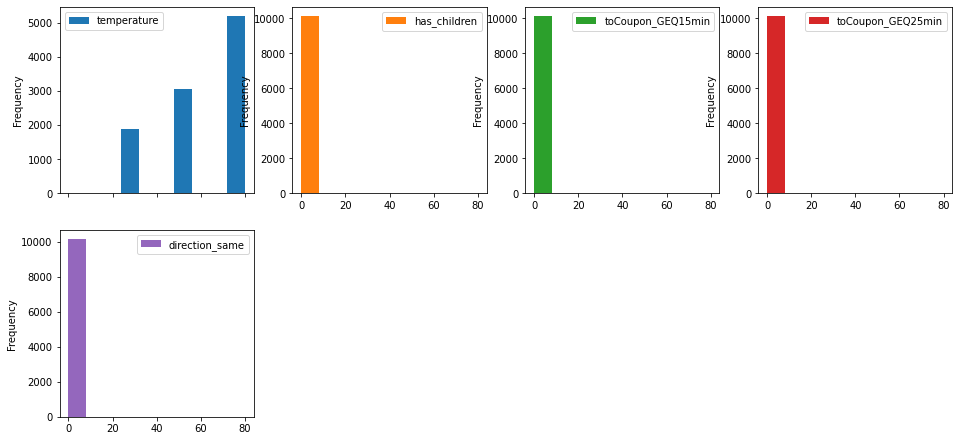

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

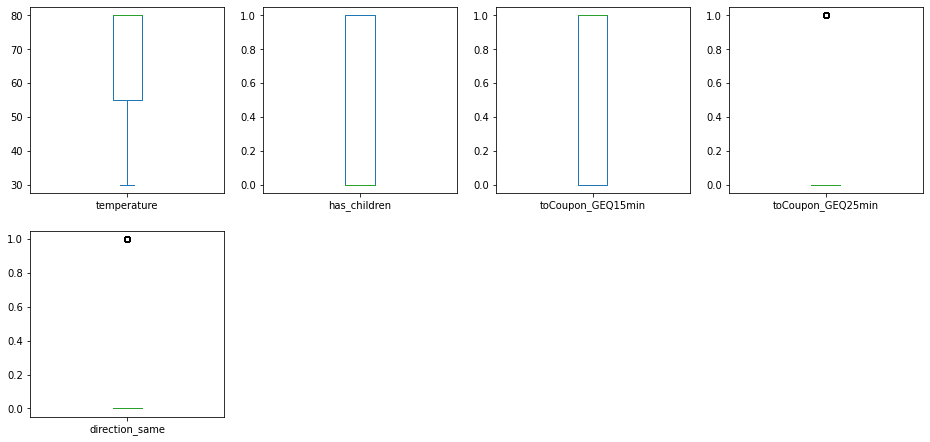

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

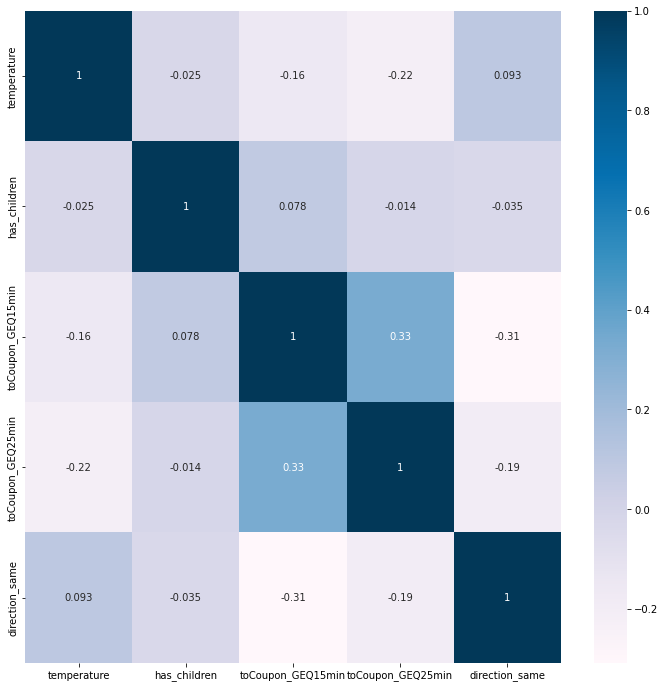

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(12, 12))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    # ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 5
Number of categorical columns: 17
Total number of columns in the feature dataframe: 22


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (10147, 22) to array_features_train.shape: (10147, 112)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (10147, 112) array_target_train.shape: (10147,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [36]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], layer1_nodes=512, layer2_nodes=512, layer3_nodes=512, layer4_nodes=512, layer5_nodes=512,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.5,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [37]:
# start_time_module = datetime.now()
# reset_random()
# baseline_model = create_nn_model()
# baseline_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
# print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model scorer from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

2021-12-13 22:33:48.270294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-13 22:33:48.270370: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-13 22:33:48.270420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (91952dc61d28): /proc/driver/nvidia/version does not exist


Score from iteration 1 >>> 0.7414
Score from iteration 2 >>> 0.7108
Score from iteration 3 >>> 0.7368
Score from iteration 4 >>> 0.7018
Score from iteration 5 >>> 0.7146
Average model scorer from all iterations: 0.7211 (0.0153)
Total time for model fitting and cross validating: 0:11:37.053811


In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00005)
final_model = create_nn_model()
# final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=1)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               57856     
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)              

### 6.b) Load Test Dataset and Make Predictions

In [42]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (2537, 112) array_target_test.shape: (2537,)


In [43]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype("int32").ravel()
print(test_predictions)

[1 0 0 ... 1 0 1]


In [44]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.7386677177769019
ROC/AUC Score: 0.7201735851633242
[[ 638  465]
 [ 198 1236]]
              precision    recall  f1-score   support

           0       0.76      0.58      0.66      1103
           1       0.73      0.86      0.79      1434

    accuracy                           0.74      2537
   macro avg       0.74      0.72      0.72      2537
weighted avg       0.74      0.74      0.73      2537



In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:14:38.939597
